# https://www.kaggle.com/datasets/oyekanmiolamilekan/fake-employee-dataset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import hashlib
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("fake_employee.csv")
df.head()

,employee_id,name,gender,dates_of_birth,email,phone_number,address,department,job_titles,manager_id,hire_date,salary,employment_status,employee_type,education_level,certifications,skills,performance_ratings,work_experience,benefits_enrollment,city,work_hours,employee_status,emergency_contacts
0,6612,Martha Hutchinson,Male,1970-11-14,randy09@example.net,708-895-4293x86180,"5301 Norman Flats Apt. 965\r\nNorth Darrell, P...",Finance,Administrator,10,2023-04-06,77367,Part-time,Regular,Master's Degree,team,"senior, kitchen, president, call, station",3,Receive determine pass find. Authority laugh r...,"data, cell, people",Hollandberg,9-5,Active,Alicia Payne: 001-469-835-3679x07176
1,4793,Meghan Cervantes,Non-Binary,1992-08-20,matthewsnyder@example.com,001-727-813-2133x30484,"7917 Vincent Trafficway Apt. 254\r\nHallhaven,...",Finance,Mental health nurse,8,2022-05-26,81869,Full-time,Temporary,PhD,"whether, some, measure","perhaps, knowledge, officer",4,Prevent meet bill computer upon keep receive. ...,"appear, discover",East Sabrinafurt,9-5,Active,Brandy Lopez: +1-642-314-0561x6900
2,8832,April Hanna,Male,1986-04-17,lwood@example.net,+1-758-402-2437x248,"646 Courtney Hollow\r\nSouth Marc, LA 67617",Finance,Field seismologist,6,2020-06-11,97907,Part-time,Temporary,PhD,"job, week","tend, official, red",4,Necessary Congress real.,"stop, woman",New Garyfurt,9-5,Active,Craig Rivera: 267.574.5240x08971
3,7044,George Yang,Non-Binary,2001-03-15,ellen93@example.net,001-682-318-3829x45513,"3930 Kelly Wells Apt. 574\r\nPaulton, OR 22142",Engineering,"Nurse, children's",5,2020-11-25,110034,Part-time,Regular,PhD,"position, similar","question, their, health, single, whole",2,Yard whose different trade. Free foreign quest...,"product, either",Christophermouth,12-8,On Leave,Lauren Davis: 423.534.7439
4,4498,Joseph Patrick,Male,1998-10-09,patriciacollins@example.net,001-790-812-0148x64174,"0493 Lane Avenue\r\nSmithburgh, IN 65374",Engineering,Meteorologist,2,2021-01-12,70091,Contractor,Contract,Bachelor's Degree,"table, seem","how, government, finally, east, strong",4,Agreement tax chair strategy bring kid assume ...,"gas, commercial",South Jamestown,Night Shift,Terminated,Antonio Ferguson: +1-425-489-9331


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   employee_id          1000 non-null   int64 
 1   name                 1000 non-null   object
 2   gender               1000 non-null   object
 3   dates_of_birth       1000 non-null   object
 4   email                1000 non-null   object
 5   phone_number         1000 non-null   object
 6   address              1000 non-null   object
 7   department           1000 non-null   object
 8   job_titles           1000 non-null   object
 9   manager_id           1000 non-null   int64 
 10  hire_date            1000 non-null   object
 11  salary               1000 non-null   int64 
 12  employment_status    1000 non-null   object
 13  employee_type        1000 non-null   object
 14  education_level      1000 non-null   object
 15  certifications       1000 non-null   object
 16  skills 

,employee_id,manager_id,salary,performance_ratings
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,5527.310000,5.454000,81531.299000,2.991000
std,2546.946895,2.837241,23216.141548,1.406021
min,1022.000000,1.000000,40027.000000,1.000000
25%,3351.500000,3.000000,61903.750000,2.000000
50%,5559.000000,5.000000,82902.000000,3.000000
75%,7732.750000,8.000000,101614.750000,4.000000
max,9995.000000,10.000000,119987.000000,5.000000


In [5]:
cols_to_remove = [
    'employee_id', 'name', 'email', 'phone_number', 'address',
    'dates_of_birth', 'skills', 'emergency_contacts'  # Removed 'manager_id' and 'work_hours' from drop list
]

# Show unique value count before dropping
print(df[cols_to_remove + ['manager_id', 'work_hours']].nunique())

# Drop only non-useful columns
df.drop([col for col in cols_to_remove if col in df.columns], axis=1, inplace=True)

# Convert manager_id and work_hours to string for categorical encoding later
df['manager_id'] = df['manager_id'].astype(str)
df['work_hours'] = df['work_hours'].astype(str)


employee_id            952
name                   995
email                  998
phone_number          1000
address               1000
dates_of_birth         974
skills                1000
emergency_contacts    1000
manager_id              10
work_hours               3
dtype: int64


# Functions

In [6]:
def preprocess_for_ml(df):
    y = df['salary']
    X = df.drop(columns=['salary'])  # Drop the target column (target = salary)

    # Replace '*' with np.nan for proper missing value handling
    X = X.replace('*', np.nan)

    # Fill missing values with a special string to retain anonymization signal
    X = X.fillna('Missing')

    # Encode categorical variables using LabelEncoder
    for col in X.select_dtypes(include='object').columns:
        encoder = LabelEncoder()
        X[col] = encoder.fit_transform(X[col].astype(str))  # Convert to string and encode

    return X, y

In [7]:


# Function to train and evaluate models
def train_and_evaluate(model, X_train, X_test, y_train, y_test, label=''):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"Model ({label}) - MAPE: {mape:.2f}")
    return mape



In [8]:
# def train_and_evaluate(model, X_train, X_test, y_train, y_test, label=''):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     mae = mean_absolute_error(y_test, y_pred)
#     mape = mean_absolute_percentage_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     print(f"Model ({label}) Results:")
#     print(f" - MAE : ${mae:,.2f}")
#     print(f" - MAPE: {mape:.2%}")
#     print(f" - R²  : {r2:.3f}")
    
#     return {
#         'model': label,
#         'mae': mae,
#         'mape': mape,
#         'r2': r2
#     }

In [9]:

# Training and evaluation function for all models
def evaluate_models(X_train, X_test, y_train, y_test):
    models = [
        (RandomForestRegressor(random_state=42), "Random Forest"),
        (LinearRegression(), "Linear Regression"),
        (DecisionTreeRegressor(random_state=42), "Decision Tree"),
        (GradientBoostingRegressor(random_state=42), "Gradient Boosting")
    ]
    
    results = {}
    for model, label in models:
        mape = train_and_evaluate(model, X_train, X_test, y_train, y_test, label)
        results[label] = mape

    return results


# Pre-processing

In [10]:
# Use the original dataset (with PII)
df_original = df.copy()



In [11]:
df[["salary"]].head()

,salary
0,77367
1,81869
2,97907
3,110034
4,70091


In [12]:
# Round salary to the nearest 5,000
df['salary'] = (df['salary'] // 5000) * 5000


In [13]:
df[["salary"]].head()

,salary
0,75000
1,80000
2,95000
3,110000
4,70000


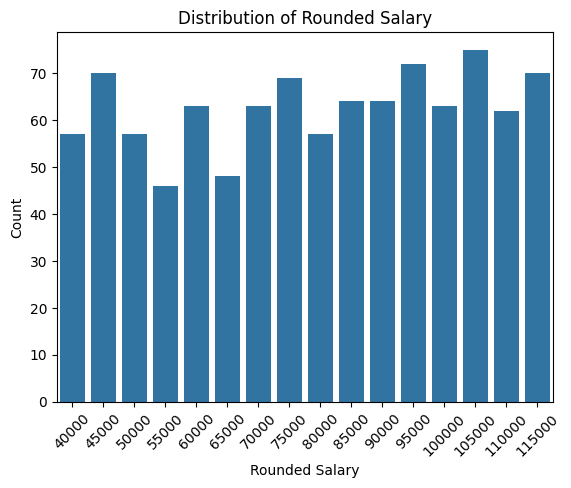

In [14]:
# Create a countplot for the rounded salary (assuming 'rounded_salary_5000' is the column)
sns.countplot(data=df, x='salary')
plt.title('Distribution of Rounded Salary')
plt.xlabel('Rounded Salary')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [15]:
X, y = preprocess_for_ml(df)  # This step should be from your previous code

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate models
model_results = evaluate_models(X_train, X_test, y_train, y_test)


Model (Random Forest) - MAPE: 0.27
Model (Linear Regression) - MAPE: 0.27
Model (Decision Tree) - MAPE: 0.36
Model (Gradient Boosting) - MAPE: 0.28


# K-1 Anonymity

In [16]:
def apply_k_anonymity(df, k):
    df = df.copy()
    
    # Define quasi-identifiers
    QIDs = ['gender', 'department', 'education_level']
    
    # Generalization based on k level
    def generalize(row):
        # Gender generalization
        if k >= 20:
            row['gender'] = np.nan
        elif k >= 15 and isinstance(row['gender'], str):
            row['gender'] = row['gender'][0].upper()
        elif k >= 5 and isinstance(row['gender'], str):
            row['gender'] = row['gender'][0].upper()

        # City generalization
        if k >= 20:
            row['city'] = np.nan
        elif k >= 15 and isinstance(row['city'], str):
            row['city'] = row['city'][0].upper()
        elif k >= 10 and isinstance(row['city'], str):
            row['city'] = row['city'][0].upper()
        elif k >= 5 and isinstance(row['city'], str):
            row['city'] = row['city'][:2]
        elif k >= 2 and isinstance(row['city'], str):
            row['city'] = row['city'][:3]

        # Department generalization
        if k >= 20:
            row['department'] = 'Unknown'
        elif k >= 15 and isinstance(row['department'], str):
            if 'IT' in row['department'] or 'Tech' in row['department']:
                row['department'] = 'Tech'
            else:
                row['department'] = 'Non-Tech'
        elif k >= 10 and isinstance(row['department'], str):
            if 'IT' in row['department'] or 'Tech' in row['department']:
                row['department'] = 'Tech'
            else:
                row['department'] = 'Other'
        elif k >= 5 and isinstance(row['department'], str):
            row['department'] = row['department'][:3]

        # Job titles generalization
        if k >= 20:
            row['job_titles'] = 'Employee'
        elif k >= 15 and isinstance(row['job_titles'], str):
            row['job_titles'] = row['job_titles'].split()[0] if row['job_titles'] else np.nan
        elif k >= 10 and isinstance(row['job_titles'], str):
            row['job_titles'] = row['job_titles'].split()[0] if row['job_titles'] else np.nan
        elif k >= 5 and isinstance(row['job_titles'], str):
            row['job_titles'] = " ".join(row['job_titles'].split()[:1])
        elif k >= 2 and isinstance(row['job_titles'], str):
            row['job_titles'] = " ".join(row['job_titles'].split()[:2])

        # Hire date generalization
        try:
            parsed_date = pd.to_datetime(row['hire_date'], errors='coerce')
            if pd.isna(parsed_date):
                row['hire_date'] = np.nan
            elif k >= 20:
                row['hire_date'] = 'Before 2020' if parsed_date.year < 2020 else '2020+'
            elif k >= 15:
                row['hire_date'] = parsed_date.year
            elif k >= 10:
                row['hire_date'] = parsed_date.year
            elif k >= 5:
                row['hire_date'] = parsed_date.strftime('%Y-%m')
            elif k >= 2:
                row['hire_date'] = parsed_date.strftime('%Y-%m')
        except:
            row['hire_date'] = np.nan

        return row

    # Apply generalization
    df = df.apply(generalize, axis=1)

    # Group by QIDs and get group sizes
    group_sizes = df.groupby(QIDs).size().reset_index(name='counts')

    # Identify groups with fewer than k
    small_groups = group_sizes[group_sizes['counts'] < k]

    # Suppression for small groups
    def suppress(row):
        is_small = ((small_groups[QIDs] == row[QIDs]).all(axis=1)).any()
        if is_small:
            for col in QIDs:
                row[col] = np.nan
        return row

    # Apply suppression
    df = df.apply(suppress, axis=1)

    # Contagem realista de células anonimizadas
    total_qid_cells = df[QIDs].size
    suppressed_cells = df[QIDs].isna().sum().sum()
    percent = (suppressed_cells / total_qid_cells) * 100

    print(f"✅ Anonymization for k={k}:")
    print(f" - Unique QID combinations: {df[QIDs].drop_duplicates().shape[0]}")
    print(f" - Suppressed cells (NaN): {suppressed_cells} / {total_qid_cells} ({percent:.2f}%)")

    return df


In [17]:
df[["salary"]]

,salary
0,75000
1,80000
2,95000
3,110000
4,70000
...,...
995,85000
996,105000
997,70000
998,45000


In [18]:
# Check how many unique values exist in each QID column
qid_check_cols = ['gender', 'department', 'education_level']
for col in qid_check_cols:
    print(f"{col}: {df[col].nunique()} unique values")


gender: 3 unique values
department: 5 unique values
education_level: 5 unique values


## K=2

In [19]:
k = 2
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k2 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=2:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)
Model (Random Forest) - MAPE: 0.27
Model (Linear Regression) - MAPE: 0.27
Model (Decision Tree) - MAPE: 0.33
Model (Gradient Boosting) - MAPE: 0.28


In [20]:
df_anonymous.head()

,gender,department,job_titles,manager_id,hire_date,salary,employment_status,employee_type,education_level,certifications,performance_ratings,work_experience,benefits_enrollment,city,work_hours,employee_status
0,Male,Finance,Administrator,10,2023-04,75000,Part-time,Regular,Master's Degree,team,3,Receive determine pass find. Authority laugh r...,"data, cell, people",Hol,9-5,Active
1,Non-Binary,Finance,Mental health,8,2022-05,80000,Full-time,Temporary,PhD,"whether, some, measure",4,Prevent meet bill computer upon keep receive. ...,"appear, discover",Eas,9-5,Active
2,Male,Finance,Field seismologist,6,2020-06,95000,Part-time,Temporary,PhD,"job, week",4,Necessary Congress real.,"stop, woman",New,9-5,Active
3,Non-Binary,Engineering,"Nurse, children's",5,2020-11,110000,Part-time,Regular,PhD,"position, similar",2,Yard whose different trade. Free foreign quest...,"product, either",Chr,12-8,On Leave
4,Male,Engineering,Meteorologist,2,2021-01,70000,Contractor,Contract,Bachelor's Degree,"table, seem",4,Agreement tax chair strategy bring kid assume ...,"gas, commercial",Sou,Night Shift,Terminated


In [21]:
# Preview of the anonymized QID columns
df_anonymous[['gender', 'department', 'education_level']].head()


,gender,department,education_level
0,Male,Finance,Master's Degree
1,Non-Binary,Finance,PhD
2,Male,Finance,PhD
3,Non-Binary,Engineering,PhD
4,Male,Engineering,Bachelor's Degree


## K=5

In [22]:

k = 5
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k5 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=5:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)
Model (Random Forest) - MAPE: 0.27
Model (Linear Regression) - MAPE: 0.27
Model (Decision Tree) - MAPE: 0.34
Model (Gradient Boosting) - MAPE: 0.28


## K=10

In [23]:
k = 10
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k10 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=10:
 - Unique QID combinations: 30
 - Suppressed cells (NaN): 21 / 3000 (0.70%)
Model (Random Forest) - MAPE: 0.27
Model (Linear Regression) - MAPE: 0.27
Model (Decision Tree) - MAPE: 0.35
Model (Gradient Boosting) - MAPE: 0.28


## K=15

In [24]:
k = 15
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k15 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=15:
 - Unique QID combinations: 19
 - Suppressed cells (NaN): 420 / 3000 (14.00%)
Model (Random Forest) - MAPE: 0.27
Model (Linear Regression) - MAPE: 0.27
Model (Decision Tree) - MAPE: 0.36
Model (Gradient Boosting) - MAPE: 0.28


## K=20

In [25]:
k = 20
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k20 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=20:
 - Unique QID combinations: 5
 - Suppressed cells (NaN): 1000 / 3000 (33.33%)
Model (Random Forest) - MAPE: 0.27
Model (Linear Regression) - MAPE: 0.27
Model (Decision Tree) - MAPE: 0.33
Model (Gradient Boosting) - MAPE: 0.28


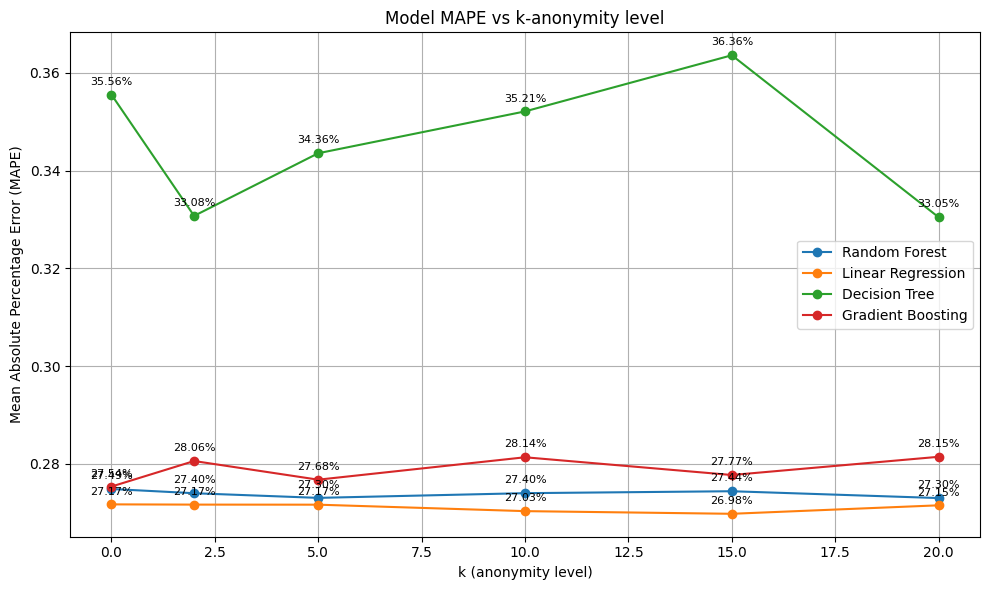

In [26]:
# Combine results from each k value
mape_summary = {
    0: model_results,
    2: model_results_k2,
    5: model_results_k5,
    10: model_results_k10,
    15: model_results_k15,
    20: model_results_k20
}

# Extract models
model_names = list(model_results_k2.keys())

plt.figure(figsize=(10, 6))

for model in model_names:
    mapes = [mape_summary[k][model] for k in sorted(mape_summary)]
    k_values = sorted(mape_summary)
    
    # Plot the line
    plt.plot(k_values, mapes, marker='o', label=model)
    
    # Add value labels for each point
    for k, mape in zip(k_values, mapes):
        plt.text(k, mape + 0.002, f"{mape:.2%}", ha='center', fontsize=8)

plt.title('Model MAPE vs k-anonymity level')
plt.xlabel('k (anonymity level)')
plt.ylabel('Mean Absolute Percentage Error (MAPE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
# # Combine results from each k value
# mae_summary = {
#     0: model_results,
#     2: model_results_k2,
#     5: model_results_k5,
#     10: model_results_k10,
#     15: model_results_k15,
#     20: model_results_k20
# }

# # Extract models
# model_names = list(model_results_k2.keys())

# # Plot MAE for each model across k values
# plt.figure(figsize=(10, 6))
# for model in model_names:
#     maes = [mae_summary[k][model] for k in sorted(mae_summary)]
#     plt.plot(sorted(mae_summary), maes, marker='o', label=model)

# plt.title('Model MAE vs k-anonymity level')
# plt.xlabel('k (anonymity level)')
# plt.ylabel('Mean Absolute Error (MAE)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Attempt to preview salary on the anonymized dataset

In [28]:
# Keep a clean reference to the original salaries
original_salaries = df['salary'].copy()

## Applying the k-anonymity to the dataset

In [29]:
k = 2 # or any k you want to test
df_anonymous = apply_k_anonymity(df.copy(), k)


✅ Anonymization for k=2:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)


## Preprocessing to train

In [30]:
X_processed, _ = preprocess_for_ml(df_anonymous)  
y_true = original_salaries  

# Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_true, test_size=0.2, random_state=42)

# Train a model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mape = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🔍 Salary prediction on anonymized data (k={k})")
print(f" - MAPE: {mape:.2f}")
print(f" - R² Score: {r2:.4f}")


🔍 Salary prediction on anonymized data (k=2)
 - MAPE: 19323.75
 - R² Score: -0.0118


## Results interpretation

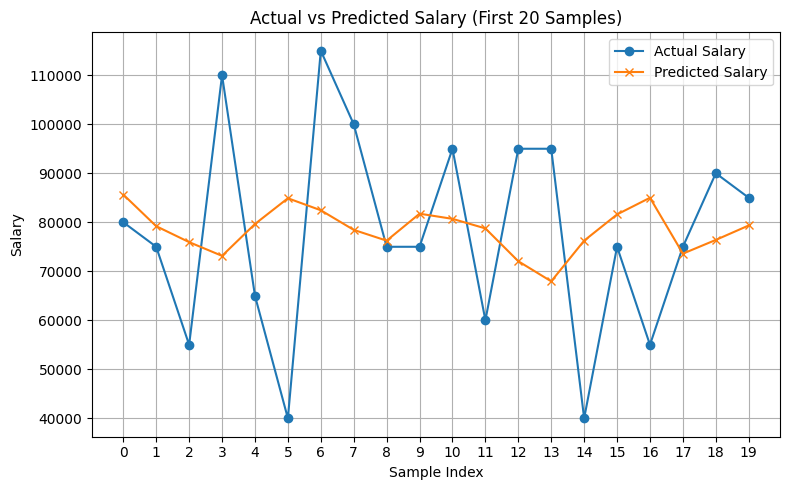

In [31]:
# Create the comparison DataFrame
comparison = pd.DataFrame({
    'Actual Salary': y_test.reset_index(drop=True),
    'Predicted Salary': y_pred
})

comparison_sample = comparison.head(20)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(comparison_sample.index, comparison_sample['Actual Salary'], label='Actual Salary', marker='o')
plt.plot(comparison_sample.index, comparison_sample['Predicted Salary'], label='Predicted Salary', marker='x')
plt.title('Actual vs Predicted Salary (First 20 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Salary')
plt.xticks(comparison_sample.index)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()